# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng" - CQ 18_21
### Giảng viên hướng dẫn: Thầy Trần Trung Kiên

### Thông tin nhóm
- STT: Nhóm 8

**Thành viên:**
1. 18120555 - Đặng Hữu Thắng
2. 18120181 - Nguyễn Thị Cẩm Hồng
3. 18120216 - Mai Huỳnh Trung Nguyên
4. 18120544 - Trương Minh Tài

Link thùng chứa Github của nhóm: [Link](https://github.com/huuthang2509/Applied_DS)

---

# Mô tả bài toán

**Bài toán:** [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/overview)

Bài toán được đưa ra bởi tổ chức tài chính quốc tế [Home Credit Group](https://en.wikipedia.org/wiki/Home_Credit), với nội dung chính của bài toán xoay quanh vấn đề vay tín dụng và tổng mức thưởng lên đến 70.000$ vào năm 2018.

Bài toán cung cấp cho chúng ta dữ liệu về các khoản vay hiện tại và trong quá khứ, thông tin cá nhân (liên quan đến **tín dụng** chứ **KHÔNG** bao gồm **danh tính**) của khách hàng, ở cả Home Credit và các tổ chức tín dụng khác.

Dựa trên dữ liệu được cung cấp đó, chúng ta sẽ tiến hành xây dựng mô hình để dự đoán tỉ lệ một khách hàng nào đó khi vay tín dụng ở Home Credit liệu có thể trả được khoản vay đó hay không?

**Độ đo** được dùng để đánh giá trong bài toán này là [Area under the ROC curve](https://machinelearningcoban.com/2017/08/31/evaluation/#-receiver-operating-characteristic-curve).

## Data Set

Dữ liệu được cung cấp bao gồm 10 files:

8 files dữ liệu chính:

- **application_train/test.csv**: đây là file data chính, bao gồm thông tin về khoản vay hiện tại và thông tin người vay

- **bureau.csv**: thông tin về các khoản vay trong quá khứ của khách hàng ở các tổ chức tín dụng khác

- **bureau_balance.csv**: thông tin cụ thể từng tháng cho từng khoản vay ở file *bureau.csv* (tháng đó đã trả nợ chưa, nếu chưa thì đã quá hạn trả bao lâu rồi, ...)

- **previous_application.csv**: thông tin về các khoản vay trong quá khứ của khách hàng ở Home Credit

- **POS_CASH_balance.csv**: thông tin cụ thể từng tháng cho từng khoản vay loại [Point of sale](https://www.jifiti.com/glossary/pos-financing/) (purchase now, pay later)

- **instalments_payments.csv**: thông tin về lịch sử trả các khoản nợ trong quá khứ ở file *previous_application.csv*

- **credit_card_balance.csv**: thông tin cụ thể từng tháng của thẻ tín dụng (nếu khách hàng có sử dụng)

và 2 file còn lại là:

- **sample_submission.csv**: mẫu kết quả nộp lên Kaggle

- **HomeCredit_columns_description.csv**: mô tả cụ thể cho từng cột trong 8 file data ở phía trên

![Data](https://github.com/huuthang2509/Applied_DS/blob/main/Image/data.png?raw=true)

# Giải quyết bài toán

Trong đồ án này, nhóm bắt đầu với bộ 9 notebook của tác giả Will Koehrsen (bắt đầu từ [notebook này](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition)) để tìm hiểu và cài đặt lại, sau đó dựa trên gợi ý từ [solution](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821) của nhóm tác giả Bojan Tunguz (đứng thứ [1] trên private leaderboard) để cải tiến mô hình.

Nhóm quyết định chọn phương thức tiếp cận này để có thể có được kiến thức tổng quát, cũng như hiểu rõ được bài toán, rồi từ đó có thể tiến hành cải tiến một cách hiệu quả, cũng như giúp các thành viên trong nhóm nắm chắc được các kiến thức mà mình học được qua các solution này.

## Import thư viện

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
# numpy và pandas
import numpy as np
import pandas as pd 

# label encode trong sklearn preprocessing
from sklearn.preprocessing import LabelEncoder

# Dùng cross-fold
from sklearn.model_selection import KFold

# import độ đo
from sklearn.metrics import roc_auc_score

# import thuật toán
import lightgbm as lgb

# chia dữ liệu
from sklearn.model_selection import train_test_split

# import thư viện để xóa các biến đã dùng, giải phóng bộ nhớ (memory)
import gc

# Ẩn đi warnings 
import warnings
warnings.filterwarnings('ignore')

# Set option để hiện tất cả các cột, dòng
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# matplotlib và seaborn để plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [3]:
# application_train.csv
app_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

SK_ID_CURR là định danh cho mỗi khoản vay ở hiện tại, là duy nhất, và của 1 khách hàng duy nhất

Dữ liệu training của chúng ta có 307511 dòng, mỗi dòng tương ứng với 1 khoản vay và 122 cột, bao gồm cả cột **TARGET** cần dự đoán

In [4]:
# application_test.csv
app_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [5]:
# bureau.csv
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
print('Bureau data shape: ', bureau.shape)
bureau.head()

Bureau data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
# bureau_balance.csv
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
print('Bureau data shape: ', bureau_balance.shape)
bureau_balance.head()

Bureau data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
# previous_application.csv
previous = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
print('Bureau data shape: ', previous.shape)
previous.head()

Bureau data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# POS_CASH_balance.csv
cash = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
print('Bureau data shape: ', cash.shape)
cash.head()

Bureau data shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [9]:
# credit_card_balance.csv
credit = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
print('Bureau data shape: ', credit.shape)
credit.head()

Bureau data shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [10]:
# installments_payments.csv
installments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
print('Bureau data shape: ', installments.shape)
installments.head()

Bureau data shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## Tìm hiểu dữ liệu (Exploratory Data Analysis)

EDA để xem thử liệu data của chúng ta có điểm gì đặc biệt, có thể rút ra được insight gì cho việc tiền xử lí cũng như modeling

### Cột **TARGET** là cột mà chúng ta cần dự đoán, kiểm tra thử xem sao

In [11]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

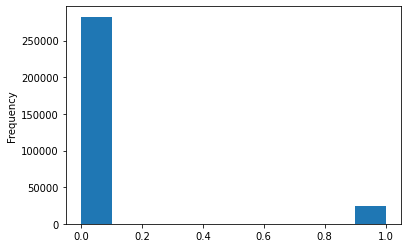

In [12]:
app_train['TARGET'].astype(int).plot.hist();

- Dữ liệu bị mất cân bằng: người trả được khoản vay nhiều hơn hắn so với không trả được, giải quyết? [Tham khảo](https://towardsdatascience.com/dealing-with-class-imbalanced-datasets-for-classification-2cc6fad99fd9)
    - Undersampling
    - Dùng model XGBoost (điều chỉnh tham số [scale_pos_weight](https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets), tuy nhiên trong này mình sẽ dùng 'is_unbalance' = True và để model tự tính)

### Missing Value

In [13]:
# Hàm tính missing value
def missing_values_table(df):
        # tổng missing value của từng col
        miss_val = df.isnull().sum()
        
        # % dữ liệu thiếu
        miss_val_percent = 100 * miss_val/len(df)
        
        # tạo dataFrame
        miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
        
        # Rename
        miss_val_table.rename(columns = {0 : 'Missing Values', 1 : 'Tỉ lệ %'}, inplace=True)
        
        # sắp xếp giảm dần tỉ lệ missing
        miss_val_table.sort_values(by='Tỉ lệ %', ascending=False, inplace=True)
        
        # chỉ lấy những col có missing value
        miss_val_table = miss_val_table[miss_val_table.iloc[:,1] != 0]
        
        # in số cột thiếu
        print ("Dataframe có: " + str(df.shape[1]) + " cột.\n"      
            "Trong đó có " + str(miss_val_table.shape[0]) + " cột có missing values.")
        
        # return
        return miss_val_table

In [14]:
# Dữ liệu thiếu trên application_train.csv
missing_values = missing_values_table(app_train)
missing_values.head(20)

Dataframe có: 122 cột.
Trong đó có 67 cột có missing values.


,Missing Values,Tỉ lệ %
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


- Có khá nhiều cột thiếu nhiều dữ liệu, xử lí bằng cách nào?
    - Điền giá trị thiếu (imputation)
    - Drop cột
    - Dùng một số model như XGBoost, framework LightGBM vì model này có thể tự [xử lí](https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4) được

In [15]:
# xóa bộ nhớ vì kaggle vẫn ko đủ ram
gc.enable()
del missing_values
gc.collect()

3497

### Kiểu dữ liệu của các cột có gì lạ không?

In [16]:
# phân bố kiểu dữ liệu trong application_train.csv
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Các cột có kiểu dữ liệu categorical (object) có bao nhiêu giá trị unique?

In [17]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

- Với các cột có nhiều giá trị unique, nếu label encoding thì sẽ gây ra hiện tượng giá trị có thứ tự, tức là model sẽ tự cho các giá trị unique trong những cột này nhận các trọng số nhất định, nhưng trên thực tế thì chưa chắc là như vậy vì có thể các giá trị này là tương đương với nhau

-> Vậy nên giải quyết bằng cách *one-hot encoding* **toàn bộ**, hoặc *label encoding* cho các cột chỉ có **2 giá trị** unique, và *one-hot encoding* cho các cột có **nhiều hơn 2 giá trị** unique

### Dùng Correlation để xem có cột nào đáng chú ý

In [18]:
# Tính Correlations giữa tất cả các cột với target và sắp xếp
correlations = app_train.corr()['TARGET'].sort_values()

# 15 giá trị có corr lớn nhất
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


**REGION_RATING_CLIENT**: rating của khu vực mà khách hàng sinh sống

**REGION_RATING_CLIENT_W_CITY**: như cột trên, tuy nhiên cụ thể hơn ở mức thành phố

Đây là 2 cột đánh giá (rating) riêng của Home Credit, và chúng ta không thể biết được chúng được đánh giá trên tiêu chí nào, vậy nên không thể rút ra insight từ 2 cột này và chúng ta sẽ chỉ sử dụng chúng như bình thường

Vậy nên chúng ta sẽ xem qua các cột khác: **DAYS_BIRTH**, **DAYS_EMPLOYED** và các **EXT_SOURCE_**

#### Xem thử cột **DAYS_BIRTH** - tuổi của khách hàng tính đến thời điểm vay

In [19]:
# chia cho -365 để chuyển từ ngày sang năm và vì dữ liệu là số âm (day before - do lấy mốc thời gian là ở khoản vay hiện tại)
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

- Có vẻ không có vấn đề gì

Vì dữ liệu ở cột **DAYS_BIRTH** này là số âm nên ta tính lại corr cho trị tuyệt đối

In [20]:
# tính lại correlation
temp_birth = abs(app_train['DAYS_BIRTH'])

temp_birth.corr(app_train['TARGET'])

-0.07823930830982694

- Corr mang giá trị âm như trên có nghĩa là giữa cột **DAYS_BIRTH** và cột **TARGET** có mối quan hệ *nghịch biến*, nghĩa là khách hàng có tuổi càng cao thì sẽ có ít khả năng vỡ nợ hơn

Chia khoảng tuổi và vẽ biểu đồ để kiểm tra thử

In [21]:
# tạo dataframe riêng
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# chia khoảng từ 20->70 tuổi thành 11 bin, tương ứng mỗi bin là 5 năm
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# group by và tính mean của từng khoảng (mean của tuổi theo ngày, tháng; và target)
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


Vẽ biểu đồ

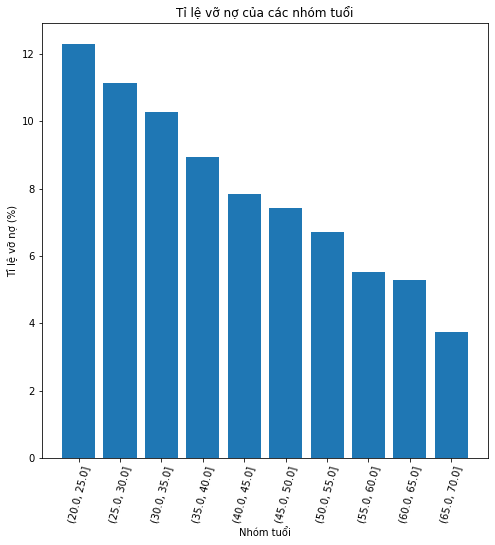

In [22]:
plt.figure(figsize = (8, 8))

# lấy YEARS_BINNED và target đã tính mean (cũng chính là tỉ lệ vỡ nợ) và chọn biểu đồ bar
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# plot
plt.xticks(rotation = 75); plt.xlabel('Nhóm tuổi'); plt.ylabel('Tỉ lệ vỡ nợ (%)')
plt.title('Tỉ lệ vỡ nợ của các nhóm tuổi');

In [23]:
gc.enable()
del age_data, age_groups, temp_birth
gc.collect()

3663

#### Xem thử cột **DAYS_EMPLOYED** - khách hàng đã đi làm được bao lâu tính đến thời điểm vay

In [24]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- Có giá trị max là 365243 ngày ~ 1000 năm -> outliers

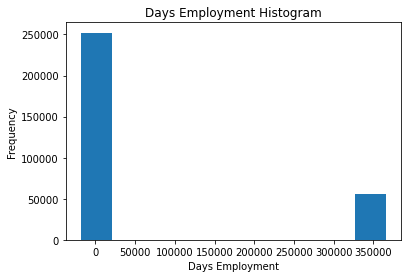

In [25]:
# vẽ biểu đồ đểm kiểm tra thử
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [26]:
outliers = app_train[app_train['DAYS_EMPLOYED'] == 365243]
not_outliers = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Tỉ lệ vỡ nợ của các khoản vay có DAYS_EMPLOYED bình thường: %0.2f%%' % (100 * not_outliers['TARGET'].mean()))
print('Tỉ lệ vỡ nợ của các khoản vay có DAYS_EMPLOYED bất thường (outliers): %0.2f%%' % (100 * outliers['TARGET'].mean()))
print('%d khoản vay có DAYS_EMPLOYED bất thường (outliers)' % len(outliers), ', chiếm tỉ lệ %0.2f%%' %(len(outliers)/len(app_train)*100))

Tỉ lệ vỡ nợ của các khoản vay có DAYS_EMPLOYED bình thường: 8.66%
Tỉ lệ vỡ nợ của các khoản vay có DAYS_EMPLOYED bất thường (outliers): 5.40%
55374 khoản vay có DAYS_EMPLOYED bất thường (outliers) , chiếm tỉ lệ 18.01%


- Có vẻ như đây không phải là outliers mà giá trị 365243 này có thể để chỉ ra các khách hàng chưa từng thất nghiệp, vì họ cũng có tỉ lệ vỡ nợ thấp hơn

-> Để tránh việc điền sai giá trị làm cho mô hình hiểu sai thì chúng ta sẽ cho các giá trị này thành *np.nan* để cho mô hình tự xử lí, đồng thời thêm 1 cột boolean để *đánh dấu* giá trị này

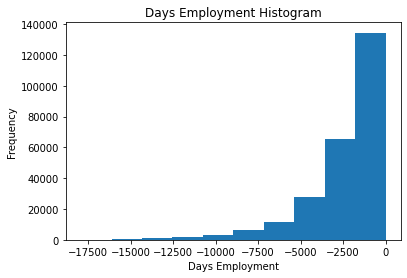

In [27]:
# tạo thêm cột boolean để đánh dấu
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# replace thành np.nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# vẽ biểu đồ để kiểm tra
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Okay, biểu đồ ổn

In [28]:
gc.enable()
del outliers, not_outliers
gc.collect()

7261

Ở phần Remove colinear bên dưới, trong lúc làm thì mình phát hiện ra giá trị này đúng thực sự là có mang thông tin, chứ không phải là outliers, và mình đã kiểm tra thêm nhiều cột có dạng 'DAYS_' khác và phát hiện các cột này cũng chứa giá trị '365243' này: 'DAYS_LAST_DUE', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'

In [29]:
previous['DAYS_FIRST_DRAWING'].describe()

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [30]:
previous[previous['DAYS_FIRST_DRAWING'] != 365243]['DAYS_FIRST_DRAWING'].describe()

count    62705.000000
mean     -1035.246791
std        922.710316
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [31]:
previous['DAYS_FIRST_DRAWING'].replace({365243: np.nan}, inplace= True)
previous['DAYS_FIRST_DUE'].replace({365243: np.nan}, inplace= True)
previous['DAYS_LAST_DUE_1ST_VERSION'].replace({365243: np.nan}, inplace= True)
previous['DAYS_LAST_DUE'].replace({365243: np.nan}, inplace= True)
previous['DAYS_TERMINATION'].replace({365243: np.nan}, inplace= True)

Ngoài ra thì mình có để ý đến một số cột khác mà mình nghĩ mình nên tìm hiểu thử xem sao

In [32]:
# set hiển thị số thay vì e+
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Đầu tiên là thu nhập

In [33]:
app_train['AMT_INCOME_TOTAL'].describe()

count      307511.00000
mean       168797.91930
std        237123.14628
min         25650.00000
25%        112500.00000
50%        147150.00000
75%        202500.00000
max     117000000.00000
Name: AMT_INCOME_TOTAL, dtype: float64

In [34]:
app_test['AMT_INCOME_TOTAL'].describe()

count     48744.00000
mean     178431.80585
std      101522.59154
min       26941.50000
25%      112500.00000
50%      157500.00000
75%      225000.00000
max     4410000.00000
Name: AMT_INCOME_TOTAL, dtype: float64

Thu nhập ở app_train có giá trị max cao bất thường

In [35]:
app_train[app_train['AMT_INCOME_TOTAL'] == 117000000]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
12840,114967,1,Cash loans,F,N,Y,1,117000000.00000,562491.00000,26194.50000,454500.00000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01064,-12615,-922.00000,-6762.00000,-3643,NaN,1,1,0,1,0,0,Laborers,3.00000,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.46081,0.11316,0.14554,0.10310,0.09470,0.97910,NaN,NaN,0.00000,0.20690,0.16670,NaN,0.06880,NaN,0.06150,NaN,NaN,0.10500,0.09830,0.97910,NaN,NaN,0.00000,0.20690,0.16670,NaN,0.07040,NaN,0.06410,NaN,NaN,0.10410,0.09470,0.97910,NaN,NaN,0.00000,0.20690,0.16670,NaN,0.07000,NaN,0.06260,NaN,NaN,NaN,block of flats,0.07150,"Stone, brick",No,0.00000,0.00000,0.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,False


Thu nhập 117 triệu đô/năm mà vẫn đi vay?? Mình sẽ thử kiểm tra các khoản vay quá khứ của khách hàng này thử

In [36]:
bureau[bureau['SK_ID_CURR'] == 114967]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
18379,114967,5192269,Active,currency 1,-125,0,964.00000,NaN,NaN,0,67500.00000,17266.50000,0.00000,0.00000,Credit card,-15,NaN
18380,114967,5192270,Active,currency 1,-50,0,315.00000,NaN,NaN,0,130846.50000,124002.00000,0.00000,0.00000,Consumer credit,-16,NaN
18381,114967,5192271,Active,currency 1,-355,0,741.00000,NaN,NaN,0,469485.00000,359023.50000,0.00000,0.00000,Consumer credit,-15,NaN
1228813,114967,5192268,Closed,currency 1,-1209,0,-1023.00000,-923.00000,NaN,0,95692.50000,0.00000,0.00000,0.00000,Consumer credit,-922,NaN


Và mình kiểm tra cả 4 khoản vay này ở bureau_balance.csv để xem quá trình trả nợ thì ko hề có thông tin, vậy nên mình chuyển qua kiểm tra bên previous và installmen_payment (dữ liệu quá khứ ở HomeCredit)

In [37]:
previous[previous['SK_ID_CURR'] == 114967]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
239657,2307071,114967,Consumer loans,5303.07000,52542.00000,52542.00000,0.00000,52542.00000,MONDAY,15,Y,1,0.00000,0.19690,0.86734,XAP,Approved,-204,Cash through the bank,XAP,NaN,Refreshed,Mobile,POS,XNA,Country-wide,32,Connectivity,12.00000,middle,POS mobile with interest,NaN,-171.00000,159.00000,NaN,NaN,0.00000
418250,1142944,114967,Consumer loans,NaN,130846.50000,130846.50000,0.00000,130846.50000,SUNDAY,12,Y,1,0.00000,NaN,NaN,XAP,Unused offer,-51,Cash through the bank,CLIENT,NaN,Repeater,Computers,XNA,XNA,Country-wide,32,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
819113,1365369,114967,Consumer loans,3948.79500,34101.00000,29601.00000,4500.00000,34101.00000,MONDAY,10,Y,1,0.14372,NaN,NaN,XAP,Approved,-2584,Cash through the bank,XAP,Other_B,New,Mobile,POS,XNA,Country-wide,25,Connectivity,10.00000,low_normal,POS mobile with interest,NaN,-2551.00000,-2281.00000,-2281.00000,-2263.00000,0.00000


In [38]:
installments[installments['SK_ID_CURR'] == 114967]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
427717,1365369,114967,1.00000,10,-2281.00000,-2267.00000,3937.63500,3937.63500
1158474,1365369,114967,1.00000,2,-2521.00000,-2514.00000,3948.79500,3948.79500
1466294,1365369,114967,1.00000,1,-2551.00000,-2546.00000,3948.79500,3948.79500
1802456,2307071,114967,1.00000,1,-171.00000,-176.00000,5303.07000,5303.07000
2283010,1365369,114967,1.00000,7,-2371.00000,-2366.00000,3948.79500,3948.79500
2297171,2307071,114967,1.00000,3,-111.00000,-113.00000,5303.07000,5303.07000
2539336,1365369,114967,1.00000,5,-2431.00000,-2447.00000,3948.79500,3948.79500
2964829,1365369,114967,1.00000,3,-2491.00000,-2496.00000,3948.79500,3948.79500
3016088,1365369,114967,1.00000,6,-2401.00000,-2420.00000,3948.79500,3948.79500
3113311,2307071,114967,1.00000,4,-81.00000,-113.00000,5303.07000,5303.07000


Các khoản nợ đều được trả đều đặn và đúng hạn, nhưng tại sao thu nhập cao vậy họ vẫn vay? Mình thấy các khoản vay ở đây tất cả đều là [POS](https://www.cnbc.com/select/what-is-a-point-of-sale-loan/), tức là khoản vay tiêu dùng -> hợp lí

In [39]:
a = app_train.drop(12840)
a['AMT_INCOME_TOTAL'].describe()

count     307510.00000
mean      168417.99278
std       108811.80735
min        25650.00000
25%       112500.00000
50%       147150.00000
75%       202500.00000
max     18000090.00000
Name: AMT_INCOME_TOTAL, dtype: float64

In [40]:
a[a['AMT_INCOME_TOTAL'] > 1000000]['SK_ID_CURR'].count()

249

Mình cũng đã thử xóa giá trị này và kiểm tra các income có mức khoảng 1x triệu thì các khoản vay cũng là POS tương tự và được trả đúng hạn. Mình nghĩ giá trị 117 triệu này có thể do nhập dư 1 số 0, tuy nhiên chỉ có 1 giá trị là rất ít nên mình sẽ giữ nguyên

Tiếp đến là số tiền vay

In [41]:
bureau['AMT_CREDIT_SUM'].describe()

count     1716415.00000
mean       354994.59192
std       1149811.34398
min             0.00000
25%         51300.00000
50%        125518.50000
75%        315000.00000
max     585000000.00000
Name: AMT_CREDIT_SUM, dtype: float64

In [42]:
bureau[bureau['AMT_CREDIT_SUM'] == 585000000]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1515147,386819,6706880,Closed,currency 1,-2683,0,-2318.00000,-2312.00000,NaN,0,585000000.00000,NaN,NaN,0.00000,Consumer credit,-2312,NaN


In [43]:
app_train[app_train['SK_ID_CURR'] == 386819]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM


In [44]:
app_test[app_test['SK_ID_CURR'] == 386819]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
38934,386819,Cash loans,M,Y,N,0,900000.00000,1800000.00000,173704.50000,1800000.00000,Unaccompanied,Working,Higher education,Married,House / apartment,0.02639,-15415,-3160.00000,-1265.00000,-4509,1.00000,1,1,1,1,1,0,Managers,2.00000,2,2,MONDAY,15,0,0,0,0,1,1,Business Entity Type 3,NaN,0.75850,0.54423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-674.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,2.00000,1.00000,False


In [45]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 6706880]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
25696701,6706880,0,C
25696702,6706880,-1,C
25696703,6706880,-2,C
25696704,6706880,-3,C
25696705,6706880,-4,C
25696706,6706880,-5,C
25696707,6706880,-6,C
25696708,6706880,-7,C
25696709,6706880,-8,C
25696710,6706880,-9,C


Trả nợ đúng hạn và đều đặn gần như tất cả các tháng. Well okay 

In [46]:
gc.enable()
del a
gc.collect()

61

#### 3 cột **EXT_SOURCE_1**, **EXT_SOURCE_2**, và **EXT_SOURCE_3** - *Normalized score from external data source*, có thể đây là điểm tín dụng *Credit Score*

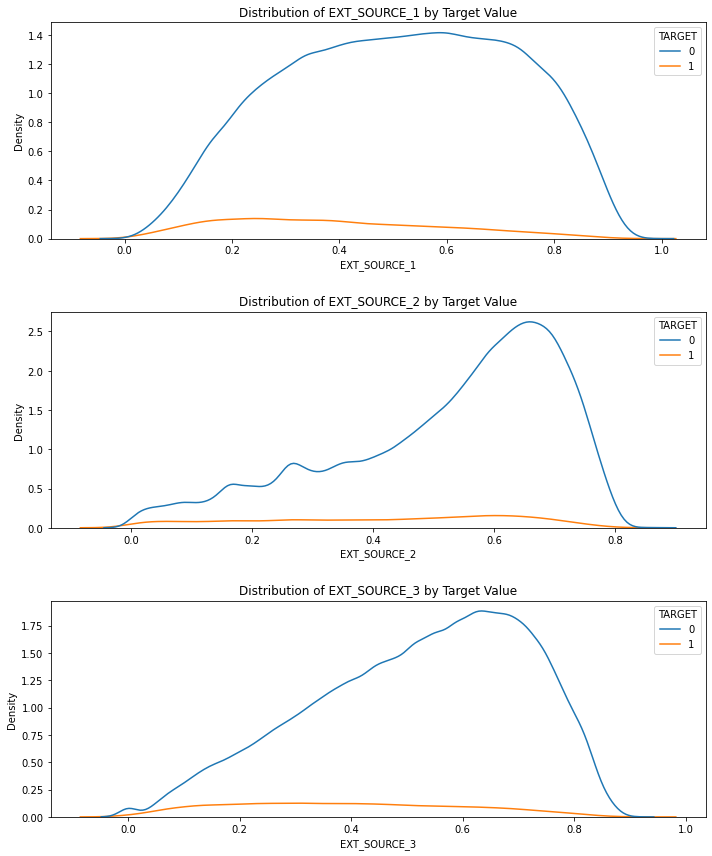

In [47]:
plt.figure(figsize = (10, 12))

# enumerate để thêm bộ đếm vòng lặp
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    #tạo subplot mới
    plt.subplot(3, 1, i + 1)
    # plot
    sns.kdeplot(data = app_train, x = app_train[source], hue = 'TARGET')
    
    # label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

- Có thể nhìn thấy rõ ở biểu đồ của **EXT_SOURCE_3** có 2 đỉnh, phần lớn những người ở khoảng 0.6 trả được nợ, còn khoảng 0.3 là không trả được nợ, tuy nhiên phân bố vẫn khá đều

## Tiền xử lí dữ liệu (Feature Engineering)

### appplication_train/test.csv

#### Categorical column

Label Encoding cho các cột có số giá trị unique <= 2

In [48]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        # label encode cho col có <= 2 giá trị unique
        if len(list(app_train[col].unique())) <= 2:
            # fit training data
            le.fit(app_train[col])
            # transform training + testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # đếm số col được label encoded
            le_count += 1
            
print('Số columns được label encoded: %d' % le_count)

Số columns được label encoded: 3


One-hot encoding cho các cột có số giá trị unique > 2

In [49]:
# one-hot encoding cho col có > 2 giá trị unique
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)


Align training và testing data, vì trong quá trình one-hot encoding, 1 trong 2 tập có thể tạo ra nhiều cột hơn vì có cột nào đó có thể có thêm giá trị unique, và mô hình cần 2 tập training và testing phải có cùng số lượng cột

In [50]:
# tách cột TARGET ra trước khi align
train_labels = app_train['TARGET']

# align
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# add lại cột TARGET
app_train['TARGET'] = train_labels

# kiểm tra xem shape có đúng ko
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


#### Polynomial Features

Các thuộc tính được tạo ra bằng các phép tính toán từ các cột ở trong data gốc. VD: EXT_SOURCE_1 ^ 2, EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2

In [51]:
# chọn các col cần
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer missing values (cập nhật cho python mới)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# tách TARGET
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# tạo polynomial object với bậc tối đa là bậc 3
poly_transformer = PolynomialFeatures(degree = 3)

# fit
poly_transformer.fit(poly_features)

# transform
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Check tên thử

In [52]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

Tính Corr xem thử các thuộc tính này liệu có tác động đến mô hình

In [53]:
# tạo dataframe
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# thêm lại col TARGET
poly_features['TARGET'] = poly_target

# tính correlations
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.19394
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.18960
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.17643
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.17228
EXT_SOURCE_1 EXT_SOURCE_2                -0.16662
EXT_SOURCE_1 EXT_SOURCE_3                -0.16407
EXT_SOURCE_2                             -0.16029
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.15687
EXT_SOURCE_3                             -0.15589
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.15082
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH   0.15589
EXT_SOURCE_2 DAYS_BIRTH                0.15687
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH   0.18128
TARGET                                 1.00000
1                                          NaN
Name: TARGET, dtype: float64


Tuy nhiên thì khi tác giả sử dụng những thuộc tính này vào mô hình thì chúng không cải thiện được điểm trên leaderboard nếu đem so sánh với khi không sử dụng

In [54]:
gc.enable()
del poly_features, poly_features_test, poly_corrs, poly_target
gc.collect()

9864

#### Domain knowledge features

Hay còn gọi là thuộc tính chuyên ngành. Ở đây tác giả tổng hợp được 4 thuộc tính

- CREDIT_INCOME_PERCENT: tỉ lệ giữa số tiền vay tín dụng so với thu nhập của khách hàng
- ANNUITY_INCOME_PERCENT: tỉ lệ giữa số tiền phải trả định kì (theo tháng) so với thu nhập của khách hàng
- CREDIT_TERM: thời hạn của khoản vay (theo tháng)
- DAYS_EMPLOYED_PERCENT: tỉ lệ giữa thâm niên làm việc so với tuổi của khách hàng

In [55]:
# tập train
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

# tập test
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 245)
Testing Features shape:  (48744, 244)


### bureau.csv và bureau_balance.csv

In [56]:
# Groupby theo client id (SK_ID_CURR), thêm cột tổng số khoản vay tín dụng trong quá khứ của khách hàng
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [57]:
# merge vào dataframe
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# khách hàng nào không có thông tin khoản vay trong quá khứ sẽ được điền số khoản vay trong quá khứ là 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_test['previous_loan_counts'] = app_test['previous_loan_counts'].fillna(0)
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Const

#### Aggregates Numeric

In [58]:
def agg_numeric(df, group_var, df_name):
    """Hàm Aggregates các cột numerictrong 1 dataframe.
    
    Tham số
    --------
        df (dataframe): 
            dataframe cần tính các số liệu thống kê (statistics)
        group_var (string): 
            cột để group by
        df_name (string): 
            tiền tố của cột được rename
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # loại bỏ các cột bắt đầu với 'SK_ID' mà ko phải là tham số mình truyền vào (loại bỏ thuộc tính định danh)
    # VD: tham số truyền vào là 'SK_ID_CURR' thì loại 'SK_ID_BUREAU',.. để giữ lại mỗi 'SK_ID_CURR'
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # tạo dataframe chỉ gồm các cột numeric
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # group by và tính thống kê statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # tạo bộ col mới để xử lí hiện tượng multi-level index
    columns = [group_var]

    # xử lí hiện tượng multi-level index
    # duyệt level 0
    for var in agg.columns.levels[0]:
        # bỏ qua cột group by
        if var != group_var:
            # duyệt qua từng cột giá trị statistic (level 1)
            for stat in agg.columns.levels[1][:-1]:
                # chuyển về thành 1 level index
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    
    #_, idx = np.unique(agg, axis = 1, return_index=True)
    #agg = agg.iloc[:, idx]
    return agg

![Multi-level Index](https://github.com/huuthang2509/Applied_DS/blob/main/Image/multi-level.png?raw=true)

#### Aggregates Categorical

![Aggregate Categorical](https://github.com/huuthang2509/Applied_DS/blob/main/Image/cate.png?raw=true)

In [59]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # tạo dataframe các cột 'object' và one hot encode, không cần loại cột định danh vì nó không phải là 'object'
    # nên sẽ không được chọn
    categorical = pd.get_dummies(df.select_dtypes('object'))

    #le = LabelEncoder()

    #for col in app_train:
    #    if app_train[col].dtype == 'object':
            # label encode cho col có <= 2 giá trị unique
    #        if len(list(app_train[col].unique())) <= 2:
                # fit training data
    #            le.fit(app_train[col])
                # transform training + testing data
    #            app_train[col] = le.transform(app_train[col])
    #            app_test[col] = le.transform(app_test[col])
            
    # thêm cột group by
    categorical[group_var] = df[group_var]

    # group by và tính sum, mean (count_norm)
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    # xử lí hiện tượng multi level-index
    column_names = []
    
    # duyệt level 0
    for var in categorical.columns.levels[0]:
        # duyệt level 1
        for stat in ['count', 'count_norm']:
            # tạo cột mới, chuyển về thành 1 level index
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [60]:
# show từng cái để kiểm tra + check multi-level index
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.00000,-49,-1572,-5145,7,0.00000,0,0,0,7,82.42857,1778.00000,-1329.00000,577.00000,4,-825.50000,-544.00000,-1328.00000,-3302.00000,0,NaN,NaN,NaN,0.00000,7,0.00000,0,0,0,7,207623.57143,378000.00000,85500.00000,1453365.00000,7,85240.92857,373239.00000,0.00000,596686.50000,6,0.00000,0.00000,0.00000,0.00000,7,0.00000,0.00000,0.00000,0.00000,7,-93.14286,-6,-155,-652,7,3545.35714,10822.50000,0.00000,24817.50000
1,100002,8,-874.00000,-103,-1437,-6992,8,0.00000,0,0,0,6,-349.00000,780.00000,-1072.00000,-2094.00000,6,-697.50000,-36.00000,-1185.00000,-4185.00000,5,1681.02900,5043.64500,0.00000,8405.14500,8,0.00000,0,0,0,8,108131.94562,450000.00000,0.00000,865055.56500,5,49156.20000,245781.00000,0.00000,245781.00000,4,7997.14125,31988.56500,0.00000,31988.56500,8,0.00000,0.00000,0.00000,0.00000,8,-499.87500,-7,-1185,-3999,7,0.00000,0.00000,0.00000,0.00000
2,100003,4,-1400.75000,-606,-2586,-5603,4,0.00000,0,0,0,4,-544.50000,1216.00000,-2434.00000,-2178.00000,3,-1097.33333,-540.00000,-2131.00000,-3292.00000,4,0.00000,0.00000,0.00000,0.00000,4,0.00000,0,0,0,4,254350.12500,810000.00000,22248.00000,1017400.50000,4,0.00000,0.00000,0.00000,0.00000,4,202500.00000,810000.00000,0.00000,810000.00000,4,0.00000,0.00000,0.00000,0.00000,4,-816.00000,-43,-2131,-3264,0,NaN,NaN,NaN,0.00000
3,100004,2,-867.00000,-408,-1326,-1734,2,0.00000,0,0,0,2,-488.50000,-382.00000,-595.00000,-977.00000,2,-532.50000,-382.00000,-683.00000,-1065.00000,1,0.00000,0.00000,0.00000,0.00000,2,0.00000,0,0,0,2,94518.90000,94537.80000,94500.00000,189037.80000,2,0.00000,0.00000,0.00000,0.00000,2,0.00000,0.00000,0.00000,0.00000,2,0.00000,0.00000,0.00000,0.00000,2,-532.00000,-382,-682,-1064,0,NaN,NaN,NaN,0.00000
4,100005,3,-190.66667,-62,-373,-572,3,0.00000,0,0,0,3,439.33333,1324.00000,-128.00000,1318.00000,1,-123.00000,-123.00000,-123.00000,-123.00000,1,0.00000,0.00000,0.00000,0.00000,3,0.00000,0,0,0,3,219042.00000,568800.00000,29826.00000,657126.00000,3,189469.50000,543087.00000,0.00000,568408.50000,3,0.00000,0.00000,0.00000,0.00000,3,0.00000,0.00000,0.00000,0.00000,3,-54.33333,-11,-121,-163,3,1420.50000,4261.50000,0.00000,4261.50000


In [61]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.42857,0,0.00000,4,0.57143,0,0.00000,7,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,7,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100002,2,0.25000,0,0.00000,6,0.75000,0,0.00000,8,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,4,0.50000,4,0.50000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100003,1,0.25000,0,0.00000,3,0.75000,0,0.00000,4,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,0.50000,2,0.50000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100004,0,0.00000,0,0.00000,2,1.00000,0,0.00000,2,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100005,2,0.66667,0,0.00000,1,0.33333,0,0.00000,3,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,0.66667,1,0.33333,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000


In [62]:
# thống kê cho từng khoản vay
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.00000,0,-96,-4656
1,5001710,83,-41.00000,0,-82,-3403
2,5001711,4,-1.50000,0,-3,-6
3,5001712,19,-9.00000,0,-18,-171
4,5001713,22,-10.50000,0,-21,-231


In [63]:
# thống kê cho từng khoản vay
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,86,0.88660,11,0.11340
5001710,5,0.06024,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,48,0.57831,30,0.36145
5001711,3,0.75000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,1,0.25000
5001712,10,0.52632,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,9,0.47368,0,0.00000
5001713,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,22,1.00000


In [64]:
# merge 2 phần numeric và category của bureau_balance lại thành 1
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# merge SK_ID_CURR vào để có thể tiếp tục tính thống kê cho từng khách hàng và merge vào app_train, app_test
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# thống kê cho từng khách hàng
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [65]:
# merge vào app_train và test
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_counts, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Const

In [66]:
print(app_train.shape)
print(app_test.shape)

(307511, 457)
(48744, 456)


In [67]:
gc.enable()
del bureau_counts, bureau_agg, bureau_balance_by_client, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance, bureau
gc.collect()

46

### previous_application.csv, POS_CASH_BALANCE.csv, credit_card_balance.csv và installments_payment.csv

In [68]:
import sys

#def return_size(df):
    #"""Return size of dataframe in gigabytes"""
    #return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # duyệt từng cột
    for c in df:
        
        # chuyển ids thành integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # chuyển objects thành category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # chuyển booleans thành integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # float64 thành float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # int64 thành int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'RAM cần dùng ban đầu: {round(original_memory / 1e9, 2)} gb.')
        print(f'RAM cần sau convert: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [69]:
app_train = convert_types(app_train, print_info=True)

RAM cần dùng ban đầu: 0.84 gb.
RAM cần sau convert: 0.44 gb.


In [70]:
previous = convert_types(previous, print_info=True)

RAM cần dùng ban đầu: 0.49 gb.
RAM cần sau convert: 0.16 gb.


In [71]:
cash = convert_types(cash, print_info=True)

RAM cần dùng ban đầu: 0.64 gb.
RAM cần sau convert: 0.29 gb.


In [72]:
credit = convert_types(credit, print_info = True)

RAM cần dùng ban đầu: 0.71 gb.
RAM cần sau convert: 0.34 gb.


In [73]:
installments = convert_types(installments, print_info = True)

RAM cần dùng ban đầu: 0.87 gb.
RAM cần sau convert: 0.44 gb.


In [74]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # xóa các cột có giá trị bị duplicate (các cột có value giống nhau)
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [75]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # xóa các cột có giá trị bị duplicate (các cột có value giống nhau)
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [76]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 85)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_DAYS_FIRST_DRAWING_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_sum,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_TERMINATION_count,previous_DAYS_LAST_DUE_count,previous_DAYS_LAST_DUE_1ST_VERSION_count,previous_DAYS_FIRST_DUE_count,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_AMT_GOODS_PRICE_count,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_count,previous_AMT_CREDIT_count,previous_AMT_APPLICATION_count,previous_CNT_PAYMENT_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,previous_SELLERPLACE_AREA_mean,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_AMT_APPLICATION_max,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_sum,previous_AMT_APPLICATION_sum,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.00000,-1740,-1709.00000,-1709.00000,-1709.00000,-1709.00000,-1619.00000,-1619.00000,-1619.00000,-1619.00000,-1612.00000,-1612.00000,-1612.00000,-1612.00000,-1499.00000,-1499.00000,-1499.00000,-1499.00000,0.00000,0.00000,0.00000,0,0.00000,0,0.00000,0.00000,0.00000,0.10433,0.10433,0.10433,0.10433,1,1,1,1,1,1,1,1,1,1,1,8.00000,8.00000,8.00000,8.00000,13,13.00000,13,13,23,23.00000,23,23,2520.00000,2520.00000,2520.00000,2520.00000,3951.00000,3951.00000,3951.00000,3951.00000,23787.00000,23787.00000,23787.00000,23787.00000,24835.50000,24835.50000,24835.50000,24835.50000,24835.50000,24835.50000,24835.50000,24835.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.00000,-606,-565.00000,-565.00000,-565.00000,-565.00000,-25.00000,-25.00000,-25.00000,-25.00000,-17.00000,-17.00000,-17.00000,-17.00000,125.00000,125.00000,125.00000,125.00000,0.00000,0.00000,0.00000,0,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,1,1,1,1,1,1,1,1,1,1,24.00000,24.00000,24.00000,24.00000,9,9.00000,9,9,500,500.00000,500,500,0.00000,0.00000,0.00000,0.00000,9251.77539,9251.77539,9251.77539,9251.77539,179055.00000,179055.00000,179055.00000,179055.00000,179055.00000,179055.00000,179055.00000,179055.00000,17905

In [77]:
app_train = app_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del previous_agg, previous
gc.collect()

0

category của previous bị out RAM, chừa lại xử lí sau

In [78]:
#previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
#print('Previous counts shape: ', previous_counts.shape)
#previous_counts.head()

In [79]:
#app_train = app_train.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
#app_test = app_test.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')

#gc.enable()
#del previous_counts, previous, previous_agg
#gc.collect()

In [80]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [81]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_max_mean,client_cash_MONTHS_BALANCE_min_max,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_max_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_min,client_cash_SK_DPD_DEF_min_min,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_min,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_min,client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_max,client_cash_NAME_CONTRACT_STATUS_XNA_sum_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum,client_cash_NAME_CONTRACT_STATUS_XNA_sum_sum,client_cash_SK_DPD_min_min,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_max,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_sum,client_cash_NAME_CONTRACT_STATUS_Demand_mean_min,client_cash_NAME_CONTRACT_STATUS_Demand_mean_mean,client_cash_NAME_CONTRACT_STATUS_Demand_mean_max,client_cash_NAME_CONTRACT_STATUS_Demand_sum_min,client_cash_NAME_CONTRACT_STATUS_Demand_sum_mean,client_cash_NAME_CONTRACT_STATUS_Demand_sum_max,client_cash_NAME_CONTRACT_STATUS_Demand_mean_sum,client_cash_NAME_CONTRACT_STATUS_Demand_sum_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_min,client_cash_NAME_CONTRACT_STATUS_Approved_sum_min,client_cash_SK_DPD_min_mean,client_cash_SK_DPD_min_max,client_cash_SK_DPD_min_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_mean,client_cash_NAME_CONTRACT_STATUS_Approved_mean_max,client_cash_NAME_CONTRACT_STATUS_Approved_sum_mean,client_cash_NAME_CONTRACT_STATUS_Approved_sum_max,client_cash_NAME_CONTRACT_STATUS_Approved_mean_sum,client_cash_NAME_CONTRACT_STATUS_Approved_sum_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_min,client_cash_SK_DPD_DEF_mean_min,client_cash_SK_DPD_mean_min,client_cash_SK_DPD_DEF_max_min,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_max_min,client_cash_SK_DPD_sum_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_sum,client_cash_NAME_CONTRACT_STATUS_Signed_mean_min,client_cash_NAME_CONTRACT_STATUS_Signed_mean_mean,client_cash_NAME_CONTRACT_STATUS_Signed_mean_max,client_cash_NAME_CONTRACT_STATUS_Signed_sum_min,client_cash_NAME_CONTRACT_STATUS_Signed_sum_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_sum,client_cash_NAME_CONTRACT_STATUS_Signed_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_min_min,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_NAME_CONTRACT_STATUS_Completed_mean_min,client_cash_NAME_CONTRACT_STATUS_Completed_mean_mean,client_cash_NAME_CONT

In [82]:
app_train = app_train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

0

In [83]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,client_credit_MONTHS_BALANCE_mean_min,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_max_mean,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_AMT_RECIVABLE_min_min,client_credit_AMT_TOTAL_RECEIVABLE_min_min,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,client_credit_AMT_RECIVABLE_min_max,client_credit_AMT_TOTAL_RECEIVABLE_min_max,client_credit_SK_DPD_min_mean,client_credit_SK_DPD_min_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_min,client_credit_NAME_CONTRACT_STATUS_Demand_sum_min,client_credit_NAME_CONTRACT_STATUS_Approved_mean_mean,client_credit_NAME_CONTRACT_STATUS_Approved_mean_sum,client_credit_NAME_CONTRACT_STATUS_Approved_sum_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_mean,client_credit_NAME_CONTRACT_STATUS_Demand_mean_max,client_credit_NAME_CONTRACT_STATUS_Demand_sum_mean,client_credit_NAME_CONTRACT_STATUS_Demand_mean_sum,client_credit_NAME_CONTRACT_STATUS_Demand_sum_max,client_credit_NAME_CONTRACT_STATUS_Demand_sum_sum,client_credit_NAME_CONTRACT_STATUS_Refused_mean_mean,client_credit_NAME_CONTRACT_STATUS_Refused_mean_sum,client_credit_NAME_CONTRACT_STATUS_Refused_sum_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_max,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_sum,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_INST_MIN_REGULARITY_min_min,client_credit_AMT_INST_MIN_REGULARITY_min_mean,client_credit_AMT_INST_MIN_REGULARITY_min_max,client_credit_AMT_INST_MIN_REGULARITY_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_min,client_credit_CNT_DRAWINGS_CURRENT_min_mean,client_credit_CNT_DRAWINGS_CURRENT_min_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_min,client_credit_AMT_DRAWINGS_CURRENT_min_mean,client_credit_AMT_DRAWINGS_CURRENT_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_min,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_mean,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_min,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_mean,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_sum,client_credit_AMT_BALANCE_min_min,client_credit_AMT_BALANCE_min_mean,client_credit_AMT_BALANCE_min_max,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_sum,client_credit_AMT_BALANCE_min_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Signed_mean_min,client_credit_NAME_CONTRACT_STATUS_Signed_mean_mean,client_credit_NAME_CONTRACT_STATUS_Signed_mean_max,client_credit_NAME_CONTRACT_STATUS_Signed_mean_sum,client_credit_NAME_CONTRACT_STATUS_Signed_sum_min,client_credit_NAME_CONTRACT_STATUS_Signed_sum_mean,client_credit_NAME_CONTRACT_STATUS_Signed_sum_max,client_credit_NAME_CONTRACT_STATUS_Signed_sum_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_sum_min,client_credit_CNT_DRAWINGS_OTHER_CURRENT_sum_mean,client_credit_CNT_DRAWINGS_OTHER_CURR

In [84]:
app_train = app_train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

0

In [85]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_installments_NUM_INSTALMENT_VERSION_max_max,client_installments_NUM_INSTALMENT_NUMBER_mean_min,client_installments_NUM_INSTALMENT_NUMBER_mean_mean,client_installments_NUM_INSTALMENT_NUMBER_mean_max,client_installments_DAYS_ENTRY_PAYMENT_count_min,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_sum_min,client_installments_DAYS_ENTRY_PAYMENT_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_NUMBER_max_min,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_NUM_INSTALMENT_NUMBER_max_max,client_installments_DAYS_ENTRY_PAYMENT_count_max,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_NUM_INSTALMENT_VERSION_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_count,client_installments_DAYS_ENTRY_PAYMENT_sum_count,client_installments_NUM_INSTALMENT_VERSION_min_sum,client_installments_NUM_INSTALMENT_VERSION_mean_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_min,client_installments_NUM_INSTALMENT_NUMBER_sum_mean,client_installments_NUM_INSTALMENT_NUMBER_min_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_max,client_installments_NUM_INSTALMENT_VERSION_max_sum,client_installments_NUM_INSTALMENT_NUMBER_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_count_sum,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_NUMBER_max_sum,client_installments_NUM_INSTALMENT_VERSION_sum_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_sum,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_INSTALMENT_min_min,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_INSTALMENT_min_max,client_installments_AMT_PAYMENT_mean_min,client_installments_AMT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_max_min,client_i

In [86]:
app_train = app_train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

0

### Feature Selection

#### Loại bỏ các cột bị thiếu nhiều hơn 75% dữ liệu

In [87]:
# kiểm tra xem có bao nhiêu cột ID
#cols_with_id = [x for x in app_train.columns if 'SK_ID_CURR' in x]
#print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))

In [88]:
# lọc các cột có missing value > 75%
train_missing = (app_train.isnull().sum() / len(app_train)).sort_values(ascending = False)
test_missing = (app_test.isnull().sum() / len(app_test)).sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('Có %d cột bị thiếu nhiều hơn 75%% dữ liệu' % len(all_missing))

Có 72 cột bị thiếu nhiều hơn 75% dữ liệu


In [89]:
# drop và kiểm tra shape
app_train.drop(columns = all_missing, inplace= True)
app_test.drop(columns = all_missing, inplace= True)
print(app_train.shape)
print(app_test.shape)

(307511, 1114)
(48744, 1113)


#### Loại bỏ các cột Collinear

In [90]:
# ngưỡng collinear
threshold = 0.9

# tính corr (lấy trị tuyệt đối)
corr_matrix = app_train.corr().abs()

# lấy nửa tam giác trên (vì dữ liệu trong bảng đối xứng)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Const

In [91]:
# lọc ra các cột bị collinear > ngưỡng đã chọn (0.9)
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('Có %d cột vượt ngưỡng.' % (len(to_drop)))

Có 536 cột vượt ngưỡng.


Mình đã kiểm tra các cột ở trong to_drop này, hầu hết đều là các cột sinh ra trong quá trình tính thống kê (aggregate), ví dụ như 'sum' và 'count' của nhiều cột là y hệt như nhau, hoặc là các giá trị cũng là thống kê median, mode, ... nhưng đã được cho sẵn trong dữ liệu. Còn lại là một số cột mà mình nghĩ là không nên loại bỏ:

- AMT_GOODS_PRICE: giá trị của khoản vay tiêu dùng
- REGION_RATING_CLIENT_W_CITY: đây là thuộc tính có corr với TARGET thuộc top cao (ở trên phần EDA)
- CODE_GENDER_M: giới tính nam
- DAYS_EMPLOYED_PERCENT: tỉ lệ giữa thâm niêm làm việc với tuổi
- ORGANIZATION_TYPE_XNA: loại tổ chức (công ty) mà khách hàng làm có giá trị XNA
- NAME_INCOME_TYPE_Pensioner: loại thu nhập là lương hưu

2 cột cuối cùng là 'ORGANIZATION_TYPE_XNA' và 'NAME_INCOME_TYPE_Pensioner' có corr rất cao với cột 'DAYS_EMPLOYED_ANOM' - cột mà mình đã thêm vào để đánh dấu các giá trị 365243

In [92]:
keep_cols_train = app_train.loc[:, ['SK_ID_CURR', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M', 'DAYS_EMPLOYED_PERCENT', 'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner']]
keep_cols_test = app_test.loc[:, ['SK_ID_CURR', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M', 'DAYS_EMPLOYED_PERCENT', 'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner']]

In [93]:
app_train.drop(columns = to_drop, inplace= True)
app_test.drop(columns = to_drop, inplace= True)
print(app_train.shape)
print(app_test.shape)

(307511, 578)
(48744, 577)


In [94]:
#app_train['REGION_POPULATION_RELATIVE'].head()

In [95]:
gc.enable()
del upper, to_drop
gc.collect()

92

#### Dựa trên Feature Importance để loại các thuộc tính có Importance = 0

In [96]:
# check xem các cột ID có bị duplicate ko
cols_with_id = [x for x in app_train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in app_train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in app_train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV


In [97]:
# tách ID khách hàng và TARGET, drop các cột bị duplicate
train_labels = app_train['TARGET']

train_ids = app_train['SK_ID_CURR']
test_ids = app_test['SK_ID_CURR']

app_train.drop(columns = cols_with_id, inplace= True)
app_train.drop(columns = 'TARGET', inplace= True)
app_test.drop(columns = cols_with_id, inplace= True)
print(app_train.shape)
print(app_test.shape)

(307511, 576)
(48744, 576)


In [98]:
# align lại data
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
print(app_train.shape)
print(app_test.shape)

(307511, 576)
(48744, 576)


In [99]:
# tạo mảng lưu các giá trị importance
feature_importances = np.zeros(app_train.shape[1])

# tạo model
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [100]:
# import thư viện để đổi tên vì bị bug trong lúc đọc tên cột
import re

In [101]:
# đổi tên
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [102]:
# kiểm tra
app_test.shape

(48744, 576)

In [103]:
# fit model 2 lần đê tính importance
for i in range(2):
    
    # chia data theo tỉ lệ 75:25
    train_features, valid_features, train_y, valid_y = train_test_split(app_train, train_labels, test_size = 0.25, random_state = i)
    
    # dúng early stopping = 100
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # lưu vào mảng đã tạo
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.784062	valid_0's binary_logloss: 0.507083
[200]	valid_0's auc: 0.785348	valid_0's binary_logloss: 0.507147


In [104]:
#temp_train = app_train
#temp_test = app_test
#temp_test.shape

In [105]:
# chia đôi importance vì duyệt 2 lần
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(app_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
202,CREDIT_TERM,170.00000
28,EXT_SOURCE_1,166.50000
29,EXT_SOURCE_2,147.50000
30,EXT_SOURCE_3,130.00000
9,DAYS_EMPLOYED,101.50000


In [106]:
# lọc ra các thuộc tính có importance = 0
zero_features = feature_importances[feature_importances['importance'] == 0.0]['feature']
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 156 features with 0.0 importance


,feature,importance
278,bureau_CREDIT_TYPE_Realestateloan_count,0.00000
275,bureau_CREDIT_TYPE_Mobileoperatorloan_count,0.00000
272,bureau_CREDIT_TYPE_Loanforworkingcapitalreplenishment_count_norm,0.00000
271,bureau_CREDIT_TYPE_Loanforworkingcapitalreplenishment_count,0.00000
110,OCCUPATION_TYPE_ITstaff,0.00000


In [107]:
#app_train = temp_train
#app_test = temp_test

In [108]:
# xóa các thuộc tính có importance = 0
app_train.drop(columns = zero_features, inplace=True)
app_test.drop(columns = zero_features, inplace=True)

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 420)
Testing shape:  (48744, 420)


In [109]:
# thêm lại cột ID và TARGET
app_train['TARGET'] = train_labels

app_train['SK_ID_CURR'] = train_ids
app_test['SK_ID_CURR'] = test_ids

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 422)
Testing shape:  (48744, 421)


# Cải tiến

In [110]:
# merge lại các cột mà mình nghĩ là không nên bỏ ở to_drop - phần Collinear
app_train = app_train.merge(keep_cols_train, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(keep_cols_test, on = 'SK_ID_CURR', how = 'left')

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 428)
Testing shape:  (48744, 427)


In [111]:
# đưa tuổi từ ngày về năm
app_train['DAYS_BIRTH'] = (app_train['DAYS_BIRTH'] / -365).astype(int)
app_test['DAYS_BIRTH'] = (app_test['DAYS_BIRTH'] / -365).astype(int)

In [112]:
# thêm các thuộc tính domain knowlegde

# tỉ lệ giá trị khoản vay tiêu dùng / giá trị khoản vay credit
app_train['credit_goods_price_ratio'] = app_train['AMT_GOODS_PRICE']/app_train['AMT_CREDIT']
app_test['credit_goods_price_ratio'] = app_test['AMT_GOODS_PRICE']/app_test['AMT_CREDIT']

# tỉ lệ thu nhập/ thâm niên làm việc
app_train['INCOME_TO_EMPLOYED_RATIO'] = app_train['AMT_INCOME_TOTAL'] / app_train['DAYS_EMPLOYED']
app_test['INCOME_TO_EMPLOYED_RATIO'] = app_test['AMT_INCOME_TOTAL'] / app_test['DAYS_EMPLOYED']

# tỉ lệ thu nhập/ tuổi
app_train['INCOME_TO_BIRTH_RATIO'] = app_train['AMT_INCOME_TOTAL'] / app_train['DAYS_BIRTH']
app_test['INCOME_TO_BIRTH_RATIO'] = app_test['AMT_INCOME_TOTAL'] / app_test['DAYS_BIRTH']

# tỉ lệ thu nhập/ số thành viên gia đình
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_test['INCOME_PER_PERSON'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_FAM_MEMBERS']

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 432)
Testing shape:  (48744, 431)


Thuộc tính về khoản nợ

In [113]:
# lấy lại data vì đã xóa ở trên
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
print('Bureau data shape: ', bureau.shape)
bureau.head()

Bureau data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00000,-153.00000,NaN,0,91323.00000,0.00000,NaN,0.00000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00000,NaN,NaN,0,225000.00000,171342.00000,NaN,0.00000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00000,NaN,NaN,0,464323.50000,NaN,NaN,0.00000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00000,NaN,NaN,0.00000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00000,NaN,77674.50000,0,2700000.00000,NaN,NaN,0.00000,Consumer credit,-21,NaN


In [114]:
# tổng số tiền nợ / tổng số tiền credit cung cấp (trong file bureau, groupby theo từng khách hàng)
credit_sum = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
credit_debt = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
debt_credit_ratio = credit_debt/credit_sum
debt_credit_diff = credit_debt - credit_sum

#rename để merge vào dataframe
debt_credit_ratio = debt_credit_ratio.rename('debt_credit_ratio')
debt_credit_diff = debt_credit_diff.rename('debt_credit_diff')

app_train = app_train.merge(debt_credit_ratio, on='SK_ID_CURR', how='left')
app_train = app_train.merge(debt_credit_diff, on='SK_ID_CURR', how='left')

app_test = app_test.merge(debt_credit_ratio, on='SK_ID_CURR', how='left')
app_test = app_test.merge(debt_credit_diff, on='SK_ID_CURR', how='left')

In [115]:
print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 434)
Testing shape:  (48744, 433)


Thuộc tính về quá trình trả nợ

In [116]:
installments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
print('Bureau data shape: ', installments.shape)
installments.head()

Bureau data shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00000,6,-1180.00000,-1187.00000,6948.36000,6948.36000
1,1330831,151639,0.00000,34,-2156.00000,-2156.00000,1716.52500,1716.52500
2,2085231,193053,2.00000,1,-63.00000,-63.00000,25425.00000,25425.00000
3,2452527,199697,1.00000,3,-2418.00000,-2426.00000,24350.13000,24350.13000
4,2714724,167756,1.00000,2,-1383.00000,-1366.00000,2165.04000,2160.58500


In [117]:
# số tiền thực tế mà khách hàng trả / số tiền phải trả theo hợp đồng (tính theo tháng)
payment = installments.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
need_to_pay = installments.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()
pay_ratio = payment/need_to_pay
pay_diff = need_to_pay - payment

#rename để merge vào dataframe
pay_ratio = pay_ratio.rename('pay_ratio')
pay_diff = pay_diff.rename('pay_diff')

app_train = app_train.merge(pay_ratio, on='SK_ID_CURR', how='left')
app_train = app_train.merge(pay_diff, on='SK_ID_CURR', how='left')

app_test = app_test.merge(pay_ratio, on='SK_ID_CURR', how='left')
app_test = app_test.merge(pay_diff, on='SK_ID_CURR', how='left')

In [118]:
print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 436)
Testing shape:  (48744, 435)


In [119]:
gc.enable()
del debt_credit_ratio, debt_credit_diff, pay_ratio, pay_diff, bureau, installments, credit_sum, credit_debt, payment, need_to_pay
gc.collect()

48

Chưa tính thống kê cho previous - kiểu categorical -> thử thêm vào

In [120]:
previous = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
print('Bureau data shape: ', previous.shape)
previous.head()

Bureau data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43000,17145.00000,17145.00000,0.00000,17145.00000,SATURDAY,15,Y,1,0.00000,0.18283,0.86734,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00000,middle,POS mobile with interest,365243.00000,-42.00000,300.00000,-42.00000,-37.00000,0.00000
1,2802425,108129,Cash loans,25188.61500,607500.00000,679671.00000,NaN,607500.00000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00000,low_action,Cash X-Sell: low,365243.00000,-134.00000,916.00000,365243.00000,365243.00000,1.00000
2,2523466,122040,Cash loans,15060.73500,112500.00000,136444.50000,NaN,112500.00000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00000,high,Cash X-Sell: high,365243.00000,-271.00000,59.00000,365243.00000,365243.00000,1.00000
3,2819243,176158,Cash loans,47041.33500,450000.00000,470790.00000,NaN,450000.00000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00000,middle,Cash X-Sell: middle,365243.00000,-482.00000,-152.00000,-182.00000,-177.00000,1.00000
4,1784265,202054,Cash loans,31924.39500,337500.00000,404055.00000,NaN,337500.00000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
previous = convert_types(previous, print_info=True)

RAM cần dùng ban đầu: 0.49 gb.
RAM cần sau convert: 0.16 gb.


In [122]:
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,previous_CHANNEL_TYPE_Car dealer_mean,previous_NAME_PORTFOLIO_Cars_mean,previous_CHANNEL_TYPE_Car dealer_sum,previous_NAME_PORTFOLIO_Cars_sum,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_TYPE_SUITE_Group of people_sum,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_sum,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_CODE_REJECT_REASON_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_sum,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_GOODS_CATEGORY_Jewelry_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,previous_NAME_GOODS_CATEGORY_Other_mean,previous_

In [123]:
# lọc collinear tương tự như ở trên đã làm
threshold = 0.9
corr_matrix = previous_counts.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,previous_CHANNEL_TYPE_Car dealer_mean,previous_NAME_PORTFOLIO_Cars_mean,previous_CHANNEL_TYPE_Car dealer_sum,previous_NAME_PORTFOLIO_Cars_sum,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_TYPE_SUITE_Group of people_sum,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_sum,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_CODE_REJECT_REASON_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_sum,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_GOODS_CATEGORY_Jewelry_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,previous_NAME_GOODS_CATEGORY_Other_mean,previous_

In [124]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 26 columns to remove.


In [125]:
previous_counts.drop(columns = to_drop, inplace= True)

print(previous_counts.shape)

(338857, 259)


In [126]:
previous_counts.head()

,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,previous_CHANNEL_TYPE_Car dealer_mean,previous_CHANNEL_TYPE_Car dealer_sum,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_TYPE_SUITE_Group of people_sum,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_sum,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_CODE_REJECT_REASON_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_sum,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_GOODS_CATEGORY_Jewelry_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,previous_NAME_GOODS_CATEGORY_Other_mean,previous_NAME_GOODS_CATEGORY_Other_sum,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_mean,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_sum,previous_NAME_GOODS_CATEGORY_Au

In [127]:
# merge vào data
app_train = app_train.merge(previous_counts, on='SK_ID_CURR', how='left')
app_test = app_test.merge(previous_counts, on='SK_ID_CURR', how='left')

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)

Training shape:  (307511, 695)
Testing shape:  (48744, 694)


In [ ]:
app_train['REGION_POPULATION_RELATIVE'] = app_train['REGION_POPULATION_RELATIVE'].round(2).astype('object')
app_test['REGION_POPULATION_RELATIVE'] = app_test['REGION_POPULATION_RELATIVE'].round(2).astype('object')

REGION_POPULATION_RELATIVE có giá trị từ 0 -> 0.07 =>> round lại là đc 7 giá trị, treat like category (phần app_train)

In [ ]:
#app_train.to_csv('final_train.csv', index = False)
#app_test.to_csv('final_test.csv', index = False)

# **Model Tuning**

# Mô hình: Gradient Boosting Machine 


## Ensemble Methods

**Ensemble Methods** (Học kết hợp) là phương pháp giải quyết bài toán bằng cách xây dựng nhiều mô hình "yếu“ (weak learner), đơn giản và kết hợp chúng là với nhau để thu được một mô hình vượt trội, thay vì xây dựng một mô hình thật sự tốt ngay từ ban đầu.

![Ensemble Methods](https://cdn.educba.com/academy/wp-content/uploads/2019/12/ensemble-method-in-machine-learning.png.webp)

> Nguồn: https://www.educba.com/ensemble-methods-in-machine-learning/

## Boosting

Là một trong 3 nhóm của Ensemble Methods (bên cạnh Bagging và Stacking).

**Boosting** là một phương pháp xây dựng một loạt các mô hình giống nhau, trong đó các mô hình sau sẽ cố gắng học để hạn chế lỗi của mô hình trước. Mỗi mô hình có thể xem là một **base model** hay weak learner.

Có 2 loại Boosting là:
- Adaptive Boosting (AdaBoost)
- Gradient Boosting

## Gradient Boosting

**Gradient Boosting** là một phương pháp xây dựng một loạt các mô hình giống nhau, trong đó các mô hình sau sẽ cố gắng học để hạn chế lỗi của mô hình trước. Thuật toán dựa vào **Gradient Descent** và ở đây mỗi base model là thường một **cây quyết định**.

Có 2 framework phổ biến nhất là **XGBoost** và **LightGBM**.

![Simple Example Gradient Boosting](https://github.com/huuthang2509/Applied_DS/blob/main/Image/examble-gradient-boosting.png?raw=true)

### Lý do lựa chọn LightGBM

- Đây là một trong những thuật toán mạnh nhất hiện nay.
- Có thể xử lý vấn đề missing value, có feature important để loại bớt các thuộc tính không cần thiết.
- Nó có tốc độ xử lý nhanh hơn rất nhiều lần so với XGBoost. (Vì XGBoost chạy rất chậm với tập dữ liệu lớn).

LightGBM sử dụng phương pháp leaf - wise:

![XGBoost vs LightGBM](https://github.com/huuthang2509/Applied_DS/blob/main/Image/LGBM.png?raw=true)

# Hyperparameter Tuning

Điều chỉnh siêu tham số (Hyperparameter Tuning) là quá trình điều chỉnh mô hình và tìm sự kết hợp của các giá trị siêu tham số cho một mô hình học máy để đạt được độ đo tốt nhất cho một vấn đề.

Có một số cách thường thấy của việc điều chỉnh siêu tham số:

1. __Thủ công__: lựa chọn siêu tham số dựa vào kinh nghiệm, suy đoán... và sau đó huấn luyện mô hình. Lặp lại các bước khi được kết quả phù hợp hoặc khi hết kiên nhẫn.
2. __Grid Search__: tạo một lưới các giá trị siêu tham số và huấn luyện mô hình, tính số điểm trên tập validation với mỗi sự kết hợp.
3. __Random search__: tạo một lưới các giá trị siêu tham số và lựa chọn ngẫu nhiên một số sự kết hợp để huấn luyện và tính điểm của mô hình. Số lần lặp lại dựa trên tài nguyên/thời gian.
4. __Automated Hyperparameter Tuning__: sử dụng các phương pháp như gradient descent, Bayesian Optiomization hoặc các thuật toán cải tiến để tìm kiếm các siêu tham số tốt nhất.

(Ta có thể xem chi tiết hơn [tại đây](https://en.wikipedia.org/wiki/Hyperparameter_optimization))

Tác giả của chuỗi Notebook sử dụng hướng tiếp cận 2,3 và 4. Nhóm đã thực hiện lại và lựa chọn Automated Hyperparameter Tuning để áp dụng và cải tiến mô hình.
Chi tiết về cách thực thi của nhóm bằng những phương pháp trên:
- [Manual Model Tuning](https://colab.research.google.com/github/huuthang2509/Applied_DS/blob/main/Manual_Model_Tuning.ipynb)
- [Automated Model Tuning](https://colab.research.google.com/github/huuthang2509/Applied_DS/blob/main/Automated_Model_Tuning.ipynb)

# Automated Model Tuning

Tác giả sử dụng phương pháp Bayesian Optimization và thư viện Hyperopt để điều chỉnh siêu tham số của GBM một cách tự động nhằm cải tiến mô hình máy học.

## Bayesian Optimization Primer

Vấn đề của grid và random search đó là chúng không phải phương pháp có sử dụng những kết quả cũ từ các giá trị khác nhau của những siêu tham số trong hàm mục tiêu. Tối ưu hóa Bayes là giới hạn các lệnh gọi đến hàm đánh giá bằng cách chọn các giá trị siêu tham số tiếp theo dựa trên các kết quả trước đó. Điều này cho phép thuật toán dành nhiều thời gian hơn để đánh giá các giá trị siêu tham số  và tốn ít thời gian hơn ở các vùng có điểm thấp của không gian siêu tham số. Ví dụ, hãy xem xét hình ảnh dưới đây:

![](https://github.com/huuthang2509/Applied_DS/blob/main/Image/random_forest_hypothetical.png?raw=true)

Như hình trên thì ta nên tập trung vào khu vực có độ lỗi thấp. Tối ưu hóa Bayes hoạt động bằng cách xây dựng một hàm thay thế (dưới dạng mô hình xác suất) của hàm mục tiêu $P(\text{score} | \text{hyperparameters})$. Hàm thay thế tốn ít chi phí hơn nhiều để đánh giá so với hàm mục tiêu, vì vậy thuật toán chọn các giá trị tiếp theo để thử trong mục tiêu dựa trên việc tối đa hóa một tiêu chí trên hàm thay thế (thường là cải tiến được mong đợi).

Hàm thay thế dựa trên kết quả đánh giá trong quá khứ. Bayesian optimization dựa trên lý luận Bayes: hình thành một mô hình và sau đó cập nhật nó với nhiều thông tin hơn. Ý tưởng ở đây là khi dữ liệu đủ nhiều, hàm thay thế ngày càng gần hàm mục tiêu, và các siêu tham số tốt nhất cho hàm thay thế cũng sẽ tốt với hàm mục tiêu. Một số lựa chọn phổ biến là Gaussian Process, Random Forest Regression, and the Tree Parzen Estimator.

### 4 Phần của Bayesian Optimization

1. __Objective Function__: hàm mục tiêu, nhận về các siêu tham số và trả về độ đo cần giảm thiểu hoặc tối ưu hoá.
2. __Domain space__: miền giá trị của các siêu tham số để tính toán
3. __Optimization Algorithm__: phương pháp sử dụng hàm thay thế và lựa chọn giá trị tiếp theo cho mô hình
4. __Results__: độ đo và các cặp giá trị để thuật toán sử dụng cho việc xây dựng hàm thay thế

## Hyperopt

Hyperopt là một thư viện Python mã nguồn mở triển khai Bayesian Optimization bằng cách sử dụng thuật toán Tree Parzen Estimator để xây dựng hàm thay thế và chọn các giá trị siêu tham số tiếp theo để đánh giá trong hàm mục tiêu.
[Hyperopt Documentation](http://hyperopt.github.io/hyperopt/)


## Dataset and Approach

Bởi vì dữ liệu của cuộc thi rất lớn (~300.000 mẫu), nếu thực hiện hết ngay từ đầu sẽ rất tốn thời gian và tài nguyên. Tác giả sẽ thực hiện trước trên tập giới hạn với 10000 dữ liệu train, 6000 dữ liệu test. Sau khi áp dụng Bayesian hyperparameter optimization trên tập giới hạn này và có được giá trị của bộ siêu tham số tối ưu. Nhóm sẽ thực hiện tiếp trên tập dữ liệu đã được tiền xử lý từ phần trước.


## Cross Validation

Chia tập train thành các tập con nhỏ đến tiến hành huấn luyện và xác thực chéo lẫn nhau. Sử dụng KFold (KFold cross validation) với n_fold = 5. Tập train sẽ được chia làm 5 phần, sau đó tiến hành train 5 lần, với mỗi lần thì sẽ dùng 1 phần làm validation và 4 phần còn lại làm dữ liệu train. Kết quả đánh giá model sẽ là trung bình cộng của 5 lần train. Hiệu suất của mỗi bộ siêu tham số sẽ được tính bằng ROC AUC. 


### Early Stopping

Siêu tham số number of estimators (số lượng cây quyết định được đào tạo tuần tự) là một trong những siêu tham số quan trọng nhất trong GBM. Phương pháp early stopping sẽ dừng quá trình train khi lỗi không giảm trong một số lần lặp nhất định. Trong bài này, tác giả áp dụng early stopping với 100 lần lặp. 

Nếu ta cứ tiếp tục huấn luyện khi độ lỗi không giảm thì có thể sai số huấn luyện sẽ giảm nhưng sẽ dẫn đến việc overfitting do mô hình quá phụ thuộc vào dữ liệu train.

## Thực hiện

### Import thư viện

In [ ]:
# Thư viện để thực hiện các thao tác trên dữ liệu
import pandas as pd
import numpy as np

# Mô hình
import lightgbm as lgb

# Đánh giá mô hình
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Trực quan hoá
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Các hằng phục vụ cho việc lựa chọn tham số
N_FOLDS = 5
MAX_EVALS = 5

### Import Data

In [ ]:
# Nhập dữ liệu train
features = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

# Chọn ra 16000 mẫu
features = features.sample(n = 16000, random_state = 42)

# Chọn ra các thuộc tính là number để tăng tốc độ tìm kiếm
features = features.select_dtypes('number')

# Tách thuộc tính TARGET riêng khỏi tập train
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Chia tập dữ liệu thành 10000 mẫu để train và 6000 mẫu để test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,22.0,1,1,0,1,0,0,4.0,2,2,11,0,0,0,0,1,1,NaN,0.364905,0.652897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,NaN,1,1,1,1,1,0,1.0,2,2,15,1,1,0,1,1,0,0.298256,0.598669,0.661024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-560.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,NaN,1,1,0,1,1,0,4.0,2,2,10,0,0,0,0,0,0,NaN,0.240739,0.577969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,0.0,-1206.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,NaN,1,1,0,1,0,0,3.0,3,3,11,0,0,0,0,1,1,0.146889,0.428255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-709.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,64.0,1,1,0,1,0,0,2.0,3,2,12,0,0,0,0,0,0,NaN,0.053220,0.569149,0.1732,0.1072,0.9742,0.6464,0.0718,0.0,0.0345,0.1667,0.2083,0.0552,...,0.0345,0.1667,0.2083,0.0562,0.1437,0.0594,0.0,0.0,0.0851,4.0,0.0,4.0,0.0,-1184.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline Model 


Ta tạo một baseline model với các siêu tham số mặc định và tính độ đo của nó.

In [ ]:
model = lgb.LGBMClassifier(random_state=50)

# Chia tập dữ liệu
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

# Chọn tham số mặc định
hyperparameters = model.get_params()

# Xoá bỏ tham số 'n_estimators' nếu có, vì ta sẽ sử dụng early stopping
del hyperparameters['n_estimators']

# Thực hiện n_folds cross validation với 100 lần lặp early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Trích xuất độ đo cv cao nhất
best = cv_results['auc-mean'][-1]

# Độ lệch chuẩn của best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.70867 with std of 0.02098.
The ideal number of iterations was 33.


Đánh giá độ đo ROC AUC trước khi điều chỉnh siêu tham số.

In [ ]:
# Tối ưu hoá số lượng vòng lặp thực thi
model.n_estimators = len(cv_results['auc-mean'])

# Huấn luyện và dự đoán kết quả
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71466 ROC AUC on the test set.


## Objective Function

Hàm tối ưu hoá thường trả về việc giảm thiếu các giá trị, còn ROC AUC tốt khi đạt giá trị cao. Cho nên hàm mục tiêu sẽ trả về $1 - \text{ROC AUC Cross Validation}$. Kết quả trả về thấp, đồng nghĩa với ROC AUC cao.

Hàm sau khi thực thi sẽ lưu các giá trị vào file csv để theo dõi kết quả

In [ ]:
import csv
# Kiểm tra trạng thái và thời gian thực thi
from hyperopt import STATUS_OK
from timeit import default_timer as timer

"""Objective function cho Gradient Boosting Machine Hyperparameter Optimization.
        Hàm nhận vào các giá trị của các siêu tham số.
        Qua mỗi lần lặp sẽ viết một dòng mới vào 'outfile'"""
def objective(hyperparameters):
      
    # Biến đếm lần lặp
    global ITERATION
    
    ITERATION += 1
    
    # Xoá bỏ tham số 'n_estimators' nếu có, vì ta sẽ sử dụng early stopping
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
         
    # Lấy subsample, cài đặt boosting_type và subsample là khoá chính của từ điển
    # Khi không có subsample thì mặc định sẽ được gán là 1.0
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Đảm bảo các tham số là số nguyên
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Thực hiện n_folds cross validation với 100 lần lặp early stopping
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Trích xuất độ đo cv cao nhất
    best_score = cv_results['auc-mean'][-1]
    
    # Tính toán giá trị loss
    loss = 1 - best_score
    
    # Số lượng vòng lặp mà thuật toán thực hiện
    n_estimators = len(cv_results['auc-mean'])
    
    # Thêm chỉ số lần lặp vào từ điển
    hyperparameters['n_estimators'] = n_estimators

    # Ghi kết quả vào file csv
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    """ Từ điển trả về bao gồm các thông tin của lần lặp: độ lỗi(loss), giá trị của các siêu tham số,
        lần lặp, thời gian thực thi, trạng thái thực thi"""
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

## Miền giá trị (Domain)

Đối với mỗi siêu tham số, miền giá trị biểu thị một phân phối xác suất chứ không được xác định tại mỗi điểm rời rạc. Sử dụng thư viện hyperopt để thể hiện điều này.

### Hyperparameters for GBM

Xem đầy đủ tại [LightGBM documentation](http://lightgbm.readthedocs.io/en/latest/Parameters.html).

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

### Miền hoàn chỉnh của Bayesian

Tác giả thực hiện thuật toán nhiều lần và lựa chọn ra các miền giá trị phù hợp. Có 10 siêu tham số được chọn.

In [ ]:
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

Kiểm tra tính đúng của hàm mục tiêu với các miền.

In [ ]:
# Tạo file csv lưu kết quả
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Tạo dòng tiêu đề
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Kiểm tra hàm mục tiêu
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.28123.
The optimal number of estimators was 53.


## Thuật toán tối ưu hoá

Thuật toán tối ưu hóa là phương pháp xây dựng hàm thay thế (mô hình xác suất) và chọn tập siêu tham số tiếp theo để đánh giá trong hàm mục tiêu. Hyperopt có hai lựa chọn: tìm kiếm ngẫu nhiên và Tree Parzen Estimator.

Chi tiết về TPE có thể xem [tại đây](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) và [đây](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).

Sơ lược về TPE:
- Tổng quan:
    - TPE đưa ra lịch sử tìm kiếm và gợi ý bộ siêu tham số cho lần thử tiếp theo
    - Áp dụng độc lập cho từng siêu tham số của miền giá trị
- Input:
    - Lịch sử tìm kiếm (bộ tham số, độ đo)
    - Biểu thức tính toán
- Output:
    - Gợi ý bộ tham số cho bước tiếp theo

In [ ]:
from hyperopt import tpe

# Khởi tạo thuật toán
tpe_algorithm = tpe.suggest

## Lịch sử các kết quả
Hyperopt có cơ chế lưu giữ lại kết quả của thuật toán, nếu ta muốn tự theo dõi thì có 2 phương pháp:

1. Một đối tượng `Trials` lưu trữ từ điển được hàm mục tiêu trả về.
2. Thêm một dòng vào file csv ở mỗi lần lặp

In [ ]:
# Sử dụng Trials
from hyperopt import Trials
trials = Trials()

# Sử dụng file csv
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

## Automated Hyperparameter Optimization trong thực tế

Ta sử dụng `fmin` để chạy Bayesian optimization.

In [ ]:
from hyperopt import fmin

`fmin` thực hiện toàn bộ 4 phần ở trên và với số lần lặp lại là `max_evals`. 

In [ ]:
# Biến đếm lần lặp
global  ITERATION

ITERATION = 0

# Thực hiện tối ưu hoá với hàm mục tiêu, miền giá trị, thuật toán tối ưu hoá, lịch sử. số lần lặp tối đa
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

{'boosting_type': 0,
 'colsample_by_tree': 0.9553013385262126,
 'gdbt_subsample': 0.6081483726857995,
 'is_unbalance': 1,
 'learning_rate': 0.012299406254863202,
 'min_child_samples': 340.0,
 'num_leaves': 142.0,
 'reg_alpha': 0.6791823081976952,
 'reg_lambda': 0.3332987025797537,
 'subsample_for_bin': 260000.0}

`best` sẽ lưu các siêu tham số cho ra giá trị thấp nhất ở hàm mục tiêu. Ta có thể xem lại cá bước thực thi thông qua `Trials` hoặc file `csv`.

In [ ]:
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.9553013385262126,
   'is_unbalance': False,
   'learning_rate': 0.012299406254863202,
   'metric': 'auc',
   'min_child_samples': 340,
   'n_estimators': 321,
   'num_leaves': 142,
   'reg_alpha': 0.6791823081976952,
   'reg_lambda': 0.3332987025797537,
   'subsample': 0.6081483726857995,
   'subsample_for_bin': 260000,
   'verbose': 1},
  'iteration': 2,
  'loss': 0.2782905721741915,
  'status': 'ok',
  'train_time': 10.110515187000033}]

In [ ]:
results = pd.read_csv(OUT_FILE)

Xây dựng hàm đánh giá, hàm này sẽ nhận kết quả, đào tạo một mô hình trên dữ liệu train và đánh giá trên dữ liệu tập test. Nó trả về một dataframes các siêu tham số.

Ta lưu kết quả vào file csv, ở file csv kết quả sẽ được lưu thành string do đó ta dùng `ast.literal_eval` để chuyển lại thành từ điển.

In [ ]:
import ast

def evaluate(results, name):
    """ Đánh giá mô hình trên dữ liệu test thông qua bộ siêu tham số của result
        Hàm trả về dataframe của các bộ siêu tham số"""
    
    new_results = results.copy()
    # Chuyển đổi kiểu string thành kiểu dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sắp xếp lại dữ liệu với giá trị tốt nhất đứng đầu
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # In ra độ đo cv
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Trích xuất bộ siêu tham số tối ưu
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Huấn luyện và dự đoán kết quả
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Tạo dataframe lưu bộ siêu tham số
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Lưu các bộ giá trị còn lại
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Ghi giá trị iteration và score vào dataframe trả về
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [ ]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.72171 found on iteration 2.
ROC AUC from Bayesian on test data = 0.73270.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,metric,verbose,n_estimators,iteration,score
0,gbdt,0.955301,False,0.012299,340,142,0.679182,0.333299,260000,0.608148,auc,1,321,2,0.721709
1,gbdt,0.871773,False,0.231936,235,35,0.776759,0.927414,80000,0.507726,auc,1,16,5,0.720484
2,goss,0.821522,True,0.016492,175,140,0.639236,0.231667,200000,1.000000,auc,1,51,1,0.719410
3,gbdt,0.850151,True,0.186834,95,142,0.669975,0.673158,120000,0.710178,auc,1,9,4,0.700181
4,gbdt,0.919643,False,0.088400,55,104,0.738352,0.757167,180000,0.972904,auc,1,20,3,0.697580


## Thực hiện trên tập Limited Data


Tác giả chạy 1000 lần tính toán trên tập dữ liệu giới hạn để so sánh. Nhóm đã thực hiện trước và lưu lại các file csv vào dataset "[Home Credit Team8 Model Tuning](https://www.kaggle.com/chnhgr/home-credit-team8-model-tuning)" nên đoạn code dưới này được comment lại.

In [ ]:
# # Thực hiện 1000 lần lặp
# MAX_EVALS = 1000

# # Tạo file để lưu kết quả
# OUT_FILE = 'bayesian_trials_1000.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# # Tạo header file
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

# # Sử dụng Trials để lưu các giá trị
# trials = Trials()

# global ITERATION

# ITERATION = 0 

# # Thực thi thuật toán
# best = fmin(fn = objective, space = space, algo = tpe.suggest,
#             trials = trials, max_evals = MAX_EVALS)

# # Sắp xếp các kết quả với giá trị có loss thấp nhất (điểm AUC cao nhất) ở đầu
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])

# print('Finished, best results')
# print(trials_dict[:1])

# # Ghi kết quả vào file
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

## Kết quả thực hiện

Kết quả thực hiện trên tập Limited Data với 1000 lần lặp. Sau bước này ta sẽ sử dụng giá trị của các siêu tham số tìm được để áp dụng cho toàn bộ dữ liệu của cuộc thi. Ở đa ta sẽ lấy dữ liệu của cả Random Search để so sánh.

In [ ]:
# Lấy lại kết quả nhóm đã thực hiện trước đó, kết quả được sắp xếp lại với giá trị tốt nhất nằm đầu tiên
bayes_results = pd.read_csv('../input/home-credit-team8-model-tuning/bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()

# Đánh giá mô hình và chọn ra bộ siêu tham số tối ưu nhất
bayes_params = evaluate(bayes_results, name = 'Bayesian')

The highest cross validation score from Bayesian was 0.72876 found on iteration 769.
ROC AUC from Bayesian on test data = 0.73010.


## Visualizations

### Độ đo ROC AUC qua mỗi lần lặp

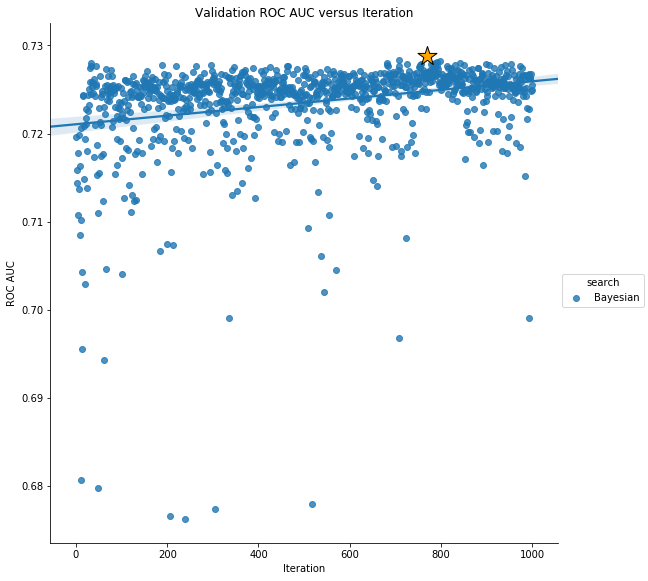

In [ ]:
# Dataframe thể hiện độ đo
scores = pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'})

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

# Giá trị tốt nhất
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

# Vẽ biểu đồ giá trị ROC AUC của mỗi lần lặp
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

## Áp dụng trên toàn bộ tập dữ liệu

Sử dụng các siêu tham số tốt nhất được tìm ra từ random search để áp dụng cho toàn bộ tập dữ liệu sau khi đã tiền xử lý của nhóm.

In [ ]:
# Đọc dữ liệu
train = pd.read_csv('../input/home-credit-team8-dataset2/final_train_2.csv')
test = pd.read_csv('../input/home-credit-team8-dataset2/final_test_2.csv')

# Tách cột ID và Target
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 416)
Testing shape:  (48744, 416)


In [ ]:
bayes_results['hyperparameters'] = bayes_results['hyperparameters'].map(ast.literal_eval)
train_set = lgb.Dataset(train, label = train_labels)
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Thực thi Cross validation
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset for Bayesian optimization = 0.78573 with std: 0.00286.
Number of estimators = 885.


In [ ]:
# Dự đoán kết quả trên tập test
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_bayesian_optimization.csv', index = False)

## Kết quả

**Kết quả của tác giả là:**
- Thời gian thực thi trên Kaggle: __3750.5s__.
- Public Leaderboard: __0.791__.

**Kết quả của Solution Top1 là:**
- Public Leaderboard: __0.80920__.
- Private Leaderboard: __0.80570__.

**Kết quả của nhóm là:**

|                            	| <font size="3"> Dataset 1 	| <font size="3"> Dataset 2 	| <font size="3"> Dataset 3 	|
|:--------------------------:	|:---------:	|:---------:	|:---------:	|
| <font size="3"> Thời gian chạy trên Kaggle 	|  <font size="3"> 1938.3s  	|  <font size="3"> 1895.4s  	|  <font size="3"> 2801.2s  	|
|     <font size="3"> Private Leaderboard    	|  <font size="3"> 0.78861  	|  <font size="3"> 0.79038  	|  <font size="3"> 0.78989  	|
|     <font size="3"> Public Leaderboard     	|  <font size="3"> 0.79260  	|  <font size="3"> 0.79421  	|  <font size="3"> 0.79321  	|
